# Exercise 12: Reinforcement Learning

In [1]:
import numpy as np
import matplotlib.pyplot as plt

##  H12.1: Value functions for mazes

### (a)

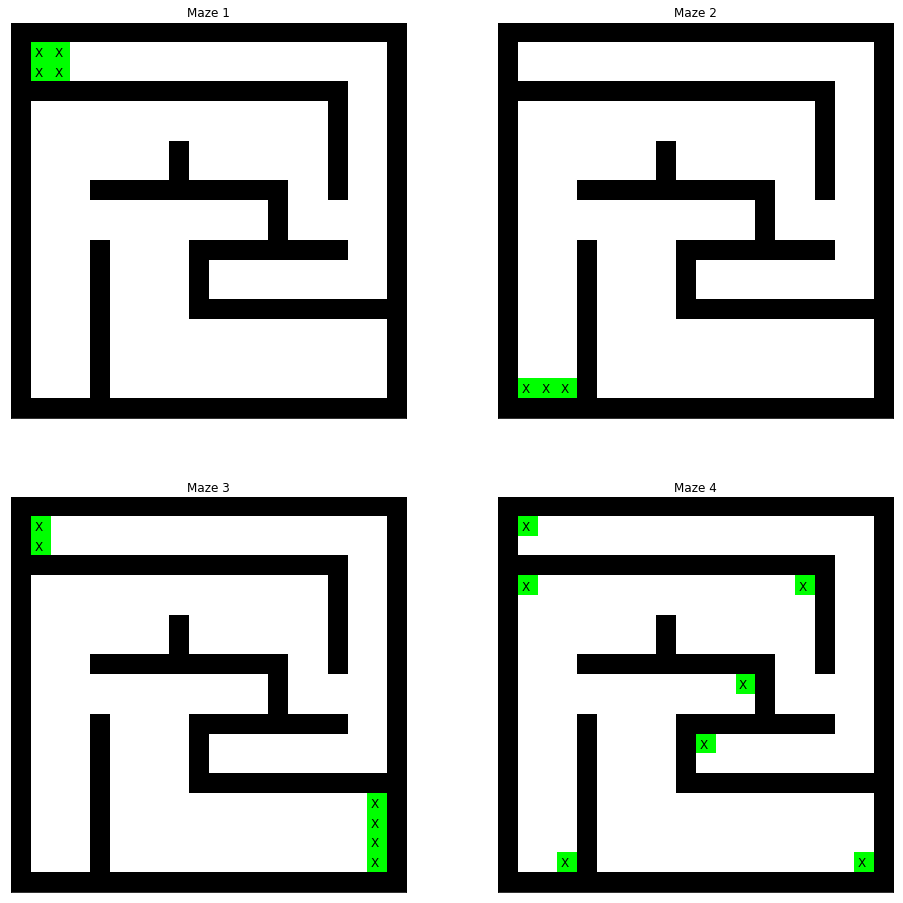

In [2]:
# read mazes from a text file
def readMazes(path = "mazes.txt"):
    
    out = []
    with open("mazes.txt") as file:
        
        skip, maze_row, maze_nr = True, 0, 0

        for line in file:
            row = line.rstrip()
            if (len(row) > 0):
                if (skip):
                    out.append([[]])
                    maze_nr += 1
                    maze_row += 1
                else:
                    out[maze_nr - 1].append([])
                    maze_row += 1
                skip = False
            else:
                maze_row = 0
                skip = True

            for c in row:
                out[maze_nr - 1][maze_row - 1].append(c)
                
    return out

# get the dimensions of a maze
def getMazeDim(maze):
    return len(maze), len(maze[0])

# create an image plot for a given maze
def setMazePlot(ax, maze, title):
    
    ax.set_title(title)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    m, n = getMazeDim(maze)
    im = np.ones((m,n,3))
    for i in range(m):
        for j in range(n):
            if (maze[i][j] == '#'):
                im[i][j] = [0,0,0]
            elif(maze[i][j] == 'X'):
                ax.text(j - 0.3, i + 0.2, 'X', fontsize=12)
                im[i][j] = [0,1,0]
            elif(maze[i][j] != ' '):
                ax.text(j - 0.3, i + 0.2, maze[i][j], fontsize=12)
                im[i][j] = [1,0.8,0]
    
    im = ax.imshow(im)
        
# TEST ------------------------------------------------

# print mazes
mazes = readMazes()
fig, axarr = plt.subplots(2, 2, figsize=(16,16))
for i in range(2):
    for j in range(2):
        setMazePlot(axarr[i][j], mazes[2*i + j], 'Maze ' + str(2*i + j + 1))
        
plt.show()


### (b)

In [3]:
# actions
A = ['right','down','left','up']

# get a list of valid states (no walls) and a list that maps these states to 'maze coordinates'
def getStates(maze):
    m, n = getMazeDim(maze)
    S, mapping = [],[]
    for i in range(m):
        for j in range(n):
            if (maze[i][j] != '#'):
                S.append(maze[i][j])
                mapping.append([i,j])
    return S, mapping
    
# computes the target (maze-)coordinates of a move
def move(a, move):
    if (move == 'right'):
        return [a[0], a[1] + 1]
    elif (move == 'down'):
        return [a[0] + 1, a[1]]
    elif (move == 'left'):
        return [a[0], a[1] - 1]
    elif (move == 'up'):
        return [a[0] - 1, a[1]]
    
# computes the transition model for a list of states and a corresponding mapping
def getTransitionModel(S, mapping, maze):

    P = np.zeros((len(S), len(S), len(A)))
    for i in range(len(S)):
        for j in range(len(S)):
            for k in range(len(A)):
                if (i == j):
                    t = move(mapping[i], A[k])
                    if (maze[t[0]][t[1]] == '#'): # check if state target is a wall (maze must be enclosed by walls)
                        P[i,j,k] = 1.0
                else:
                    P[i,j,k] = (move(mapping[i], A[k]) == mapping[j]) + 0.0

    return P


# TEST ------------------------------------------------

mazes = readMazes()
maze = mazes[0] # test with first maze

S, mapping = getStates(maze)
P = getTransitionModel(S, mapping, maze) 

# why plot? just sum differences..
D = P.sum(axis = 1)
print ("total dif (must be zero):", np.sum(np.absolute(D - np.ones(D.shape))))

total dif (must be zero): 0.0


### (c)

log of value functions:


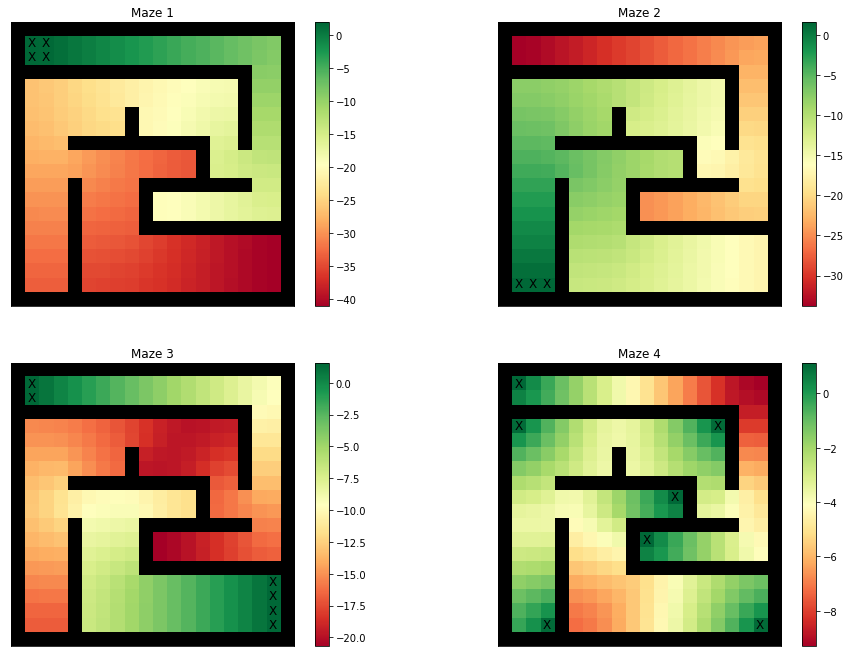

In [4]:
# get the reward mapping
def getRewards(A, S):
    reward = np.zeros((len(A), len(S)))
    for k in range(len(A)):
        for i in range(len(S)):
            reward[k, i] = (S[i] == 'X') + 0.0
    return reward

# get the uniform policy mapping
def getUniformPolicy(A, S):
    policy = np.zeros((len(A), len(S)))
    for k in range(len(A)):
        for i in range(len(S)):
            policy[k,i] = 1.0 / len(A) 
    return policy

# compute the analytical value function
def getAnalyticalValueFunc(reward, policy, P, df):
    
    c_reward = np.sum(reward * policy, axis = 0)   
    c_transition = np.sum(P * np.transpose(policy, (1,0))[:,None, :], axis = 2)
    
    return np.dot(np.linalg.inv(np.identity(c_reward.size) - df * c_transition), c_reward)

# create an image plot for the anlytical value function
def setValueFuncPlot(ax, fig, S, mapping, policy, reward, P, maze):

    val = getAnalyticalValueFunc(reward, policy, P, 0.9)
    
    # if the value is zero we snap to the lowest value > 0 to make computation possible
    snap_value = np.min(val[np.where(val > 0)])
    value = np.where(val > 0, np.log(val), np.log(snap_value))

    m, n = getMazeDim(maze)
    
    plot = np.zeros((m,n))
    walls = np.zeros((m,n,4))
    walls[:,:,3] = np.ones((m,n))

    for s in range(len(S)):
        i, j = mapping[s][0], mapping[s][1]

        plot[i][j] = value[s] # value

        walls[i][j] = [0,0,0,0] # walls
        
        if (S[s] == 'X'):  # X - markers
            ax.text(j - 0.3, i + 0.2, 'X', fontsize=12)
            
    plot = ax.imshow(plot, cmap='RdYlGn')
    walls = ax.imshow(walls)
    
    cbar = fig.colorbar(plot, ax=ax)
    
# TEST ------------------------------------------------
    
mazes = readMazes()
rows = np.ceil(len(mazes)/2).astype(int)
fig, axarr = plt.subplots(rows, 2, figsize=(16,24))
print ("log of value functions:")
for i in range(rows):
    for j in range(2):
        ax = axarr[i][j]
        nr = 2*i + j
        ax.set_title('Maze ' + str(nr + 1))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if (nr < 4): # only the first 4 here
            S, mapping = getStates(mazes[nr])
            P = getTransitionModel(S, mapping, mazes[nr]) 
            policy = getUniformPolicy(A,S)
            reward = getRewards(A,S)
            setValueFuncPlot(axarr[i][j], fig, S, mapping, policy, reward, P, mazes[nr])
        else:
            ax.set_visible(False)
plt.show()


The walls are not states and not problematic, as they do not appear anywhere in the computation. They are only relevant to compute the transition model.

### (d)

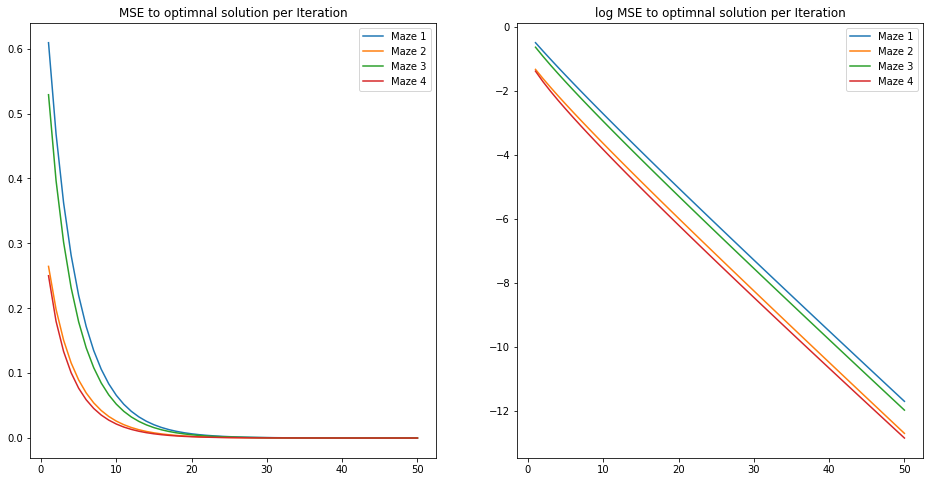

In [5]:
# compute the MSE for the first n iterations (difference to analytical solution)
def getValueIterationError(reward, policy, P, df, n):

    c_reward = np.sum(reward * policy, axis = 0)
    c_transition = np.sum(P * np.swapaxes(policy, 0, 1)[None, :, :], axis = 2)
    
    ana_sol = getAnalyticalValueFunc(reward, policy, P, df)
    
    value = np.zeros(P.shape[0])
    MSE = np.zeros(n)
    
    for i in range(n):
        
        value = c_reward + np.dot(df * c_transition, value)
        
        MSE[i] = ((value - ana_sol) ** 2).mean()
        
    return MSE

def plotErrorAndLog(x1, y1, x2, y2, title1, title2, ):
    
    fig, axarr = plt.subplots(1, 2, figsize=(16,8))
    handles = [[],[]]

    handles[0].append(axarr[0].plot(range(1,51), err, label = 'Maze ' + str(k+1))[0])
    handles[1].append(axarr[1].plot(range(1,51), errlog, label = 'Maze ' + str(k+1))[0])
    


    
# TEST ------------------------------------------------
    
mazes = readMazes()

fig, axarr = plt.subplots(1, 2, figsize=(16,8))
handles,  handles_log = [], []

for k in range(4):
    
    S, mapping = getStates(mazes[k])
    P = getTransitionModel(S, mapping, mazes[k]) 
    
    policy = getUniformPolicy(A,S)
    reward = getRewards(A,S)
    err = getValueIterationError(reward, policy, P, 0.9, 50)
    errlog = np.where(err > 0, np.log(err), np.finfo(float).min)

    handles.append(axarr[0].plot(range(1,51), err, label = 'Maze ' + str(k+1))[0])
    handles_log.append(axarr[1].plot(range(1,51), errlog, label = 'Maze ' + str(k+1))[0])

axarr[0].legend(handles=handles)
axarr[0].set_title('MSE to optimnal solution per Iteration')

axarr[1].legend(handles=handles_log)
axarr[1].set_title('log MSE to optimnal solution per Iteration')

plt.show()


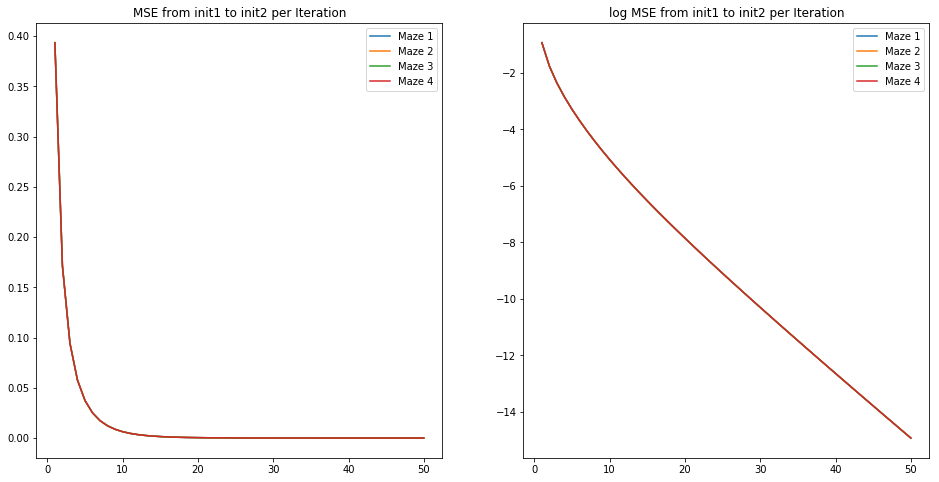

In [6]:
# compute MSE between two randomly chosen value vectors per Bellman iteration
def getContractionDif(reward, policy, P, df, n, init1, init2):

    c_reward = np.sum(reward * policy, axis = 0)
    c_transition = np.sum(P * np.swapaxes(policy, 0, 1)[None, :, :], axis = 2)
    
    D = np.zeros(n)
    
    for i in range(n):
        
        init1 = c_reward + np.dot(df * c_transition, init1)
        init2 = c_reward + np.dot(df * c_transition, init2)
        
        D[i] = ((init1 - init2) ** 2).mean()
        
    return D


# TEST ------------------------------------------------
    
mazes = readMazes()
fig, axarr = plt.subplots(1, 2, figsize=(16,8))

handles = []
handles_log = []

S, mapping = getStates(mazes[0])
init1 = np.random.normal(size = (len(S)))
init2 = np.random.normal(size = (len(S)))

for k in range(4):
    
    S, mapping = getStates(mazes[k])
    P = getTransitionModel(S, mapping, mazes[k]) 
    
    policy = getUniformPolicy(A,S)
    reward = getRewards(A,S)

    err = getContractionDif(reward, policy, P, 0.9, 50, init1, init2)

    errlog = np.where(err > 0, np.log(err), np.finfo(float).min)

    handles.append(axarr[0].plot(range(1,51), err, label = 'Maze ' + str(k+1))[0])
    handles_log.append(axarr[1].plot(range(1,51), errlog, label = 'Maze ' + str(k+1))[0])

axarr[0].legend(handles=handles)
axarr[0].set_title('MSE from init1 to init2 per Iteration')

axarr[1].legend(handles=handles_log)
axarr[1].set_title('log MSE from init1 to init2 per Iteration')

plt.show()

There is no difference between the values for the four mazes. Computing the MSE for two iterated values by hand, we notice that the 'controlled reward' is eliminated and the resulting MSE only depends on the previous values, the discount factor, the policy and the transition model. These values however, are the same for each maze, since only the reward is different.

## H12.2: Find a good policy

### a)

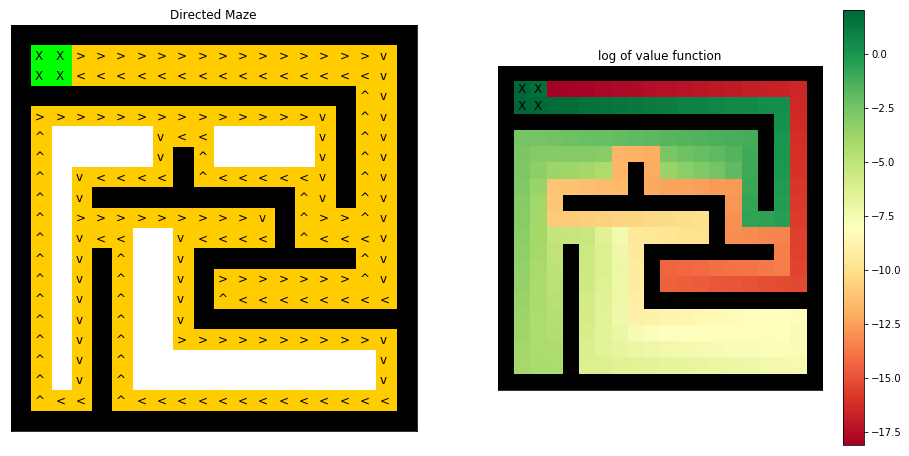

In [7]:
def getSpecialPolicy(A, S):
    policy = np.zeros((len(A), len(S)))
    for k in range(len(A)):
        for i in range(len(S)):
            if (S[i] == 'X' or S[i] == ' '):
                policy[k,i] = 1.0 / len(A)
            elif (S[i] == '>'):
                policy[k,i] = (A[k] == 'right') + 0.0
            elif (S[i] == '<'):
                policy[k,i] = (A[k] == 'left') + 0.0
            elif (S[i] == '^'):
                policy[k,i] = (A[k] == 'up') + 0.0
            elif (S[i] == 'v'):
                policy[k,i] = (A[k] == 'down') + 0.0
    return policy

def plotMazeAndValue(maze, S, mapping, policy, reward, P, title):
    
    fig, axes = plt.subplots(1, 2, figsize=(16,8))
    
    axes[0].set_title(title)
    axes[1].set_title('log of value function')
    
    for i in [0, 1]:
        axes[i].get_xaxis().set_visible(False)
        axes[i].get_yaxis().set_visible(False)
    
    setMazePlot(axes[0], maze, title)
    setValueFuncPlot(axes[1], fig, S, mapping, policy, reward, P, maze)
    
    plt.show()

# TEST ------------------------------------------------

# actions
A = ['right','down','left','up']

mazes = readMazes()
special_maze = mazes[4] # directed maze

S, mapping = getStates(special_maze)
P = getTransitionModel(S, mapping, special_maze) 
policy = getSpecialPolicy(A,S)
reward = getRewards(A,S)

plotMazeAndValue(special_maze, S, mapping, policy, reward, P, 'Directed Maze')


### b)

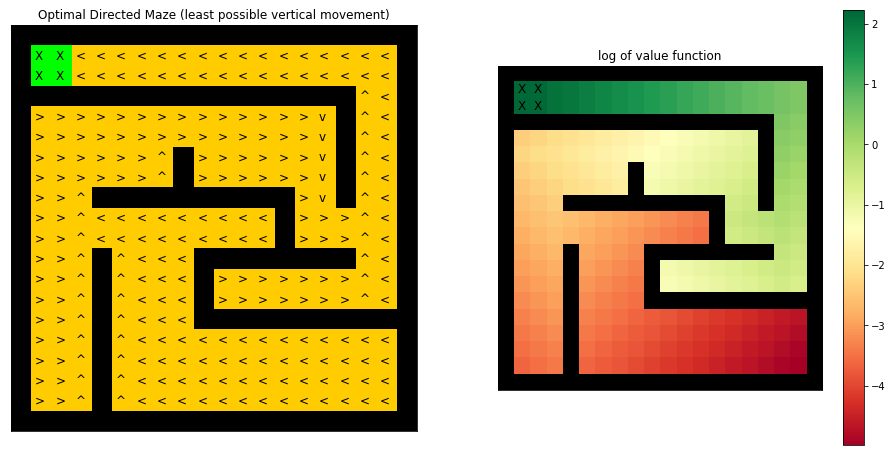

In [8]:
# actions
A = ['right','down','left','up']

mazes = readMazes()
special_maze = mazes[5]# an optimal directed maze (least possible vertical movement)

# TEST ------------------------------------------------

S, mapping = getStates(special_maze)
P = getTransitionModel(S, mapping, special_maze) 
policy = getSpecialPolicy(A,S)
reward = getRewards(A,S)

plotMazeAndValue(special_maze, S, mapping, policy, reward, P, 'Optimal Directed Maze (least possible vertical movement)')

### c)

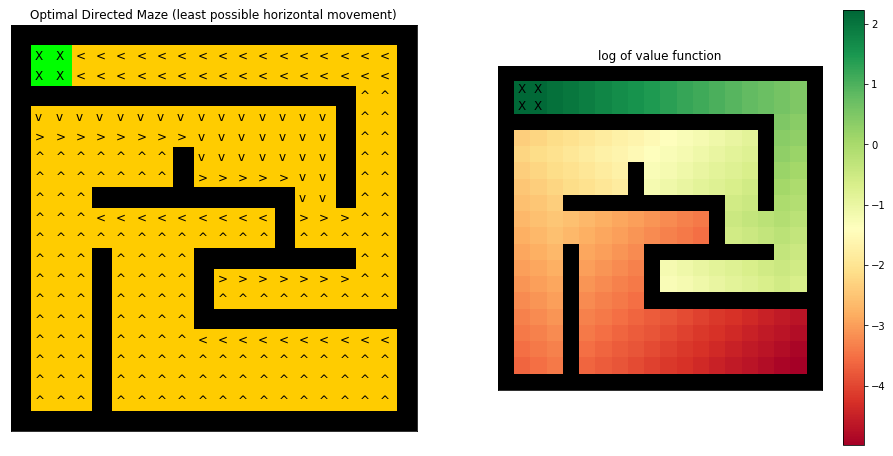

In [9]:
# actions
A = ['right','down','left','up']

mazes = readMazes()
special_maze = mazes[6]# an optimal directed maze (least possible horizontal movement)

# TEST ------------------------------------------------

S, mapping = getStates(special_maze)
P = getTransitionModel(S, mapping, special_maze) 
policy = getSpecialPolicy(A,S)
reward = getRewards(A,S)

plotMazeAndValue(special_maze, S, mapping, policy, reward, P, 'Optimal Directed Maze (least possible horizontal movement)')

### d)